## 2D UNet Train with Band 13 Satellite Data

Since tile **images are downloaded in 3 different time ranges**, and we don't want data within one group has big time gaps, we separated them into 3 groups.

#### Datasets:
- D:\Tommy\++AI\++datasets\jv_h9_Data\B13\Groups\np_all_zones_b13_gp1.npy  (178MB)
- D:\Tommy\++AI\++datasets\jv_h9_Data\B13\Groups\np_all_zones_b13_gp2.npy  (1.18GB)
- D:\Tommy\++AI\++datasets\jv_h9_Data\B13\Groups\np_all_zones_b13_gp3.npy  (897MB)

- #### gp1.npy
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_e1_b08_gp1_tile_4_13_6.npy   (东部1个tile)
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_m2_b08_gp1_2tiles.npy        (中部2个tile裁剪）
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_ne1_b08_gp1_tile_4_13_5.npy （东北1个tile)
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_ne4_b08_gp1_4tiles.npy      （东北4个tile裁剪)
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_s4_b08_gp1_4tiles.npy       （南部4个tile裁剪)
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_w1_b08_gp1_tile_4_12_6.npy   (西部1个tile)
    
- #### gp2.npy
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_e1_b08_gp2_tile_4_13_6.npy 
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_m2_b08_gp2_2tiles.npy 
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_ne1_b08_gp2_tile_4_13_5.npy 
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_ne4_b08_gp2_4tiles.npy 
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_s4_b08_gp2_4tiles.npy 
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_w1_b08_gp2_tile_4_12_6.npy 
    
- #### gp3.npy
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_e1_b08_gp3_tile_4_13_6.npy 
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_m2_b08_gp3_2tiles.npy 
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_ne1_b08_gp3_tile_4_13_5.npy 
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_ne4_b08_gp3_4tiles.npy 
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_s4_b08_gp3_4tiles.npy 
    - D:\Tommy\++AI\++datasets\jv_h9_Data\B08\MultipleZones\np_w1_b08_gp3_tile_4_12_6.npy 

### 1. Import Libraries

In [51]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import math

In [27]:
ds = np.load(r'D:\Tommy\++AI\himawari9\jvtest\np_b13_zone_South_China_norm_class.npy')
ds.min(),ds.max(),ds.shape

(0.0, 1.0, (1149, 256, 256))

#### this is a test, only load small data in one zone

In [52]:
class H9Dataset(Dataset):
    def __init__(self, file_path,in_len, out_len, steps, transform=None):
        self.in_len = in_len          # length of input frames
        self.out_len = out_len        # length of output frames
        self.total = in_len+out_len   # total length of both frames, this more like a moving window
        self.steps = steps            # how many frames to skip on each window moving
        
        #all tile images
        ds_all=[]
        #max number of sets depend on output length
        ds_pos=[]
        # (1813,256,256)
        ds = np.load(r'D:\Tommy\++AI\himawari9\jvtest\np_b13_tile_4_12_6.npy')
        ds_all.append(ds/255)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)
        ds = np.load(r'D:\Tommy\++AI\himawari9\jvtest\np_b13_tile_4_13_5.npy')
        ds_all.append(ds/255)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)
        ds = np.load(r'D:\Tommy\++AI\himawari9\jvtest\np_b13_tile_4_13_6.npy')
        ds_all.append(ds/255)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)
        ds = np.load(r'D:\Tommy\++AI\himawari9\jvtest\np_b13_zone_mid_China.npy')
        ds_all.append(ds/255)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)
        ds = np.load(r'D:\Tommy\++AI\himawari9\jvtest\np_b13_zone_NE_Part_China.npy')
        ds_all.append(ds/255)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)
        (1149,256,256)
        # this dataset has been normalized
        ds = np.load(r'D:\Tommy\++AI\himawari9\jvtest\np_b13_zone_South_China_norm_class.npy')
        ds_all.append(ds)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)
        self.ds_all = ds_all
        self.ds_pos = ds_pos
        print('max number of sets', ds_pos)
                
        self.transform = transform

    def __len__(self):
        return sum(self.ds_pos)
    
    def __getitem__(self, i):
        num_list=0
        num_in_list = 0
        cumulative_sum = 0
        for k, length in enumerate(self.ds_pos):
            cumulative_sum += length
            if i < cumulative_sum:
                num_list,num_in_list = k, i - (cumulative_sum - length)
                break
        #print(num_list,num_in_list)
        
        ds_element = self.ds_all[num_list]
        #print(ds_element.shape)
        data_seg =  ds_element[(num_in_list)*self.steps:(num_in_list)*self.steps+self.total,:,:]
        
        data_ins = data_seg[:self.in_len,:,:]
        data_outs = data_seg[self.in_len:, :, :]#[:, np.newaxis, :, :]
        #print('data_ins', data_ins.shape)
        #print('data_outs', data_outs.shape)
        t_inputs = torch.tensor(data_ins,dtype=torch.float32)
        t_targets = torch.tensor(data_outs,dtype=torch.float32)
        if self.transform:
            t_inputs = self.transform(t_inputs)
            t_targets = self.transform(t_targets)
            
        return t_inputs,t_targets
        


In [53]:
# Define the transform
tile_size = 128
transform = transforms.Compose([
    transforms.Resize((tile_size, tile_size))
])

In [54]:
# since the path for data files are hard coded in data object, this file_path below won't be loaded
train = H9Dataset(file_path = r'D:\Tommy\++AI\++datasets\jv_h9_Data\B13\Groups\np_all_zones_b13_gp1.npy', 
                  in_len = 12, 
                  out_len = 6,
                  steps = 6,
                  transform=None
                 )

max number of sets [300, 300, 300, 300, 300, 189]


In [55]:
ins,outs = train.__getitem__(0)

In [56]:
ins.shape,outs.shape

(torch.Size([12, 256, 256]), torch.Size([6, 256, 256]))

In [57]:
train.__len__()

1689

In [58]:
ins.max()

tensor(1.)

#### Sequencial 18 frames (12 input + 6 Targets) 

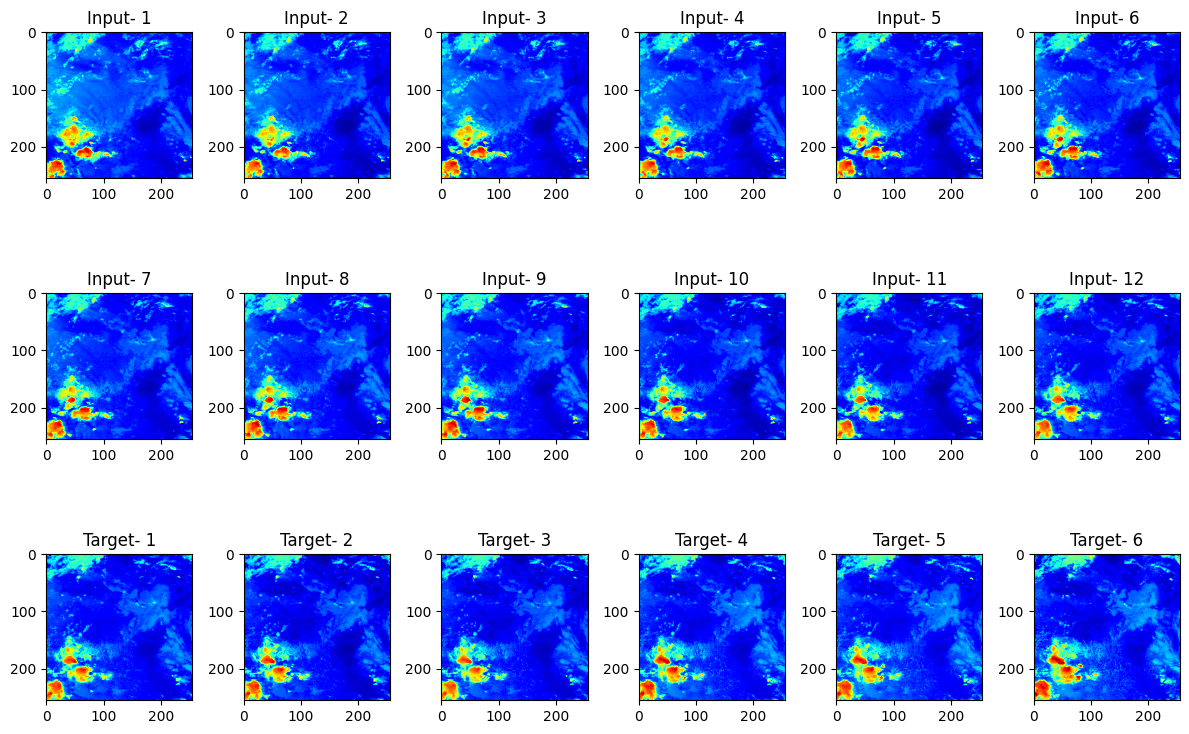

In [59]:
import matplotlib.pyplot as plt
import numpy as np
# Create a figure and an array of subplots
fig, axes = plt.subplots(3, 6, figsize=(12,8))

for j in range(6):
    axes[0,j].imshow(ins[j,:,:],cmap='jet')
    axes[0,j].set_title(f'Input- {j+1}')
for j in range(6):
    axes[1,j].imshow(ins[j+6,:,:],cmap='jet')
    axes[1,j].set_title(f'Input- {j+7}')

for j in range(6):
    axes[2,j].imshow(outs[j,:,:],cmap='jet')
    axes[2,j].set_title(f'Target- {j+1}')

plt.tight_layout()
plt.show()

#### Get 100th elements

In [60]:
ins,outs = train.__getitem__(100)

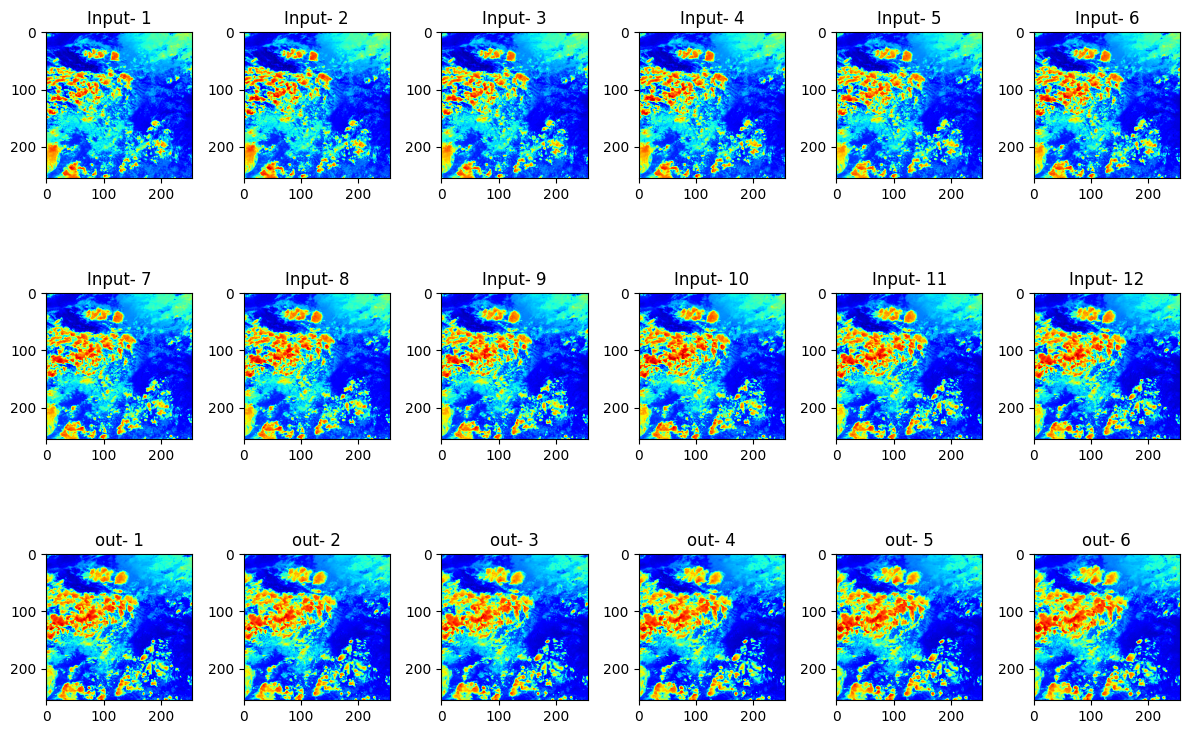

In [61]:
import matplotlib.pyplot as plt
import numpy as np
# Create a figure and an array of subplots
fig, axes = plt.subplots(3, 6, figsize=(12,8))

for j in range(6):
    axes[0,j].imshow(ins[j,:,:],cmap='jet')
    axes[0,j].set_title(f'Input- {j+1}')
for j in range(6):
    axes[1,j].imshow(ins[j+6,:,:],cmap='jet')
    axes[1,j].set_title(f'Input- {j+7}')

for j in range(6):
    axes[2,j].imshow(outs[j,:,:],cmap='jet')
    axes[2,j].set_title(f'out- {j+1}')

plt.tight_layout()
plt.show()

### 2.3 Train Loader

In [62]:
bs = 8
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=bs, shuffle=True)

### 3. Setup UNet Model

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [64]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3):
        super(ConvBlock, self).__init__()
        # kernel_size=3
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [65]:
class UNet2D(nn.Module):
    def __init__(self, in_channels, out_channels,output_frames, features=[64, 128, 256, 512]):
        super(UNet2D, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        #self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.output_frames = output_frames

        # Encoder
        for feature in features:
            self.encoder.append(ConvBlock(in_channels, feature))
            in_channels = feature
                  
        # Decoder
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(ConvBlock(feature*2, feature))

        self.bottleneck = ConvBlock(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        #self.time_conv = nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=(12, 1, 1), stride=(1, 1, 1))

    def forward(self, x):
        skip_connections = []
                    
        #Encoder
        for encoder in self.encoder:
            x = encoder(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        
        # Decoder
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:], mode='nearest')
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](concat_skip)

        return self.final_conv(x)


### 4. Train

In [66]:
import torch
import torchvision
from torch import optim
#from tqdm import tqdm
from tqdm.notebook import tqdm
import torchvision.utils as torchutils

In [67]:
epochs=10
lr=1e-4
bs=8
best_loss = float('inf')

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model initialization
in_channels = 12  # band08 and band13
out_channels = 6  # Only band13 for output
output_frames = 6

# Initialize the model
model = UNet2D(in_channels=12, out_channels=6,output_frames=6)
model.to(device)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=bs, shuffle=True)

Using device: cuda


In [68]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# Define the scheduler
# mode='min' ensures the learning rate decreases when the loss does not decrease
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.05, verbose=True)

In [69]:
def dice_loss(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

def custom_loss(pred, target):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return bce * 0.5 + dice * 0.5

In [70]:
import pytorch_ssim
# 自定义损失函数，包括BCE、Dice和SSIM
def custom_loss(pred, target):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)

    # 初始化SSIM损失
    ssim_loss_total = 0.0
    time_steps = pred.size(2)  # 获取时间帧数
    
    
    # 逐帧计算SSIM, for dim = 5
    #for t in range(time_steps):
    #    ssim_loss_total += pytorch_ssim.ssim(pred[:,:,  t, :, :], target[:,:,  t, :, :])
    # for dim =4, can directly calculate
    ssim_loss_total = pytorch_ssim.ssim(pred, target)

    # 取平均SSIM损失
    ssim_loss = ssim_loss_total / time_steps
    
    return bce * 0.4 + dice * 0.4 + (1 - ssim_loss) * 0.2

In [79]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
        
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
        optimizer.zero_grad()
        outputs = model(batch_x)
        #loss = criterion(outputs, batch_y)
        loss = custom_loss(outputs, batch_y)
        
        # save model
        if loss < best_loss:
            print('=== best loss: ',loss)
            best_loss = loss
            torch.save(model.state_dict(), r'D:\Tommy\++AI\himawari9\jvtest\models\unet_2D_AllZones_Dataset_best.pth')
            
        loss.backward()
        optimizer.step()
            
        train_loss += loss.item()
    train_loss = train_loss/len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")
    
    # Step the scheduler based on training loss
    scheduler.step(train_loss)  # Reduce LR if train_loss hasn't improved for 'patience' epochs
    # Print learning rate and losses
    current_lr = optimizer.param_groups[0]['lr']
    print('current lr: ',current_lr)
    # Log metrics to wandb
    #wandb.log({"epoch": epoch+1, "train_loss": avg_loss})
    if epoch%5==0:
        np.save(f"D:/Tommy/++AI/himawari9/jvtest/models/npy_files/target_2d_{epoch}.npy",batch_x.cpu().numpy())
        np.save(f"D:/Tommy/++AI/himawari9/jvtest/models/npy_files/predict_2d_{epoch}.npy",outputs.detach().cpu().numpy())

Epoch 1/100, Train Loss: 0.6379
current lr:  0.0001
Epoch 2/100, Train Loss: 0.6381
current lr:  0.0001
Epoch 3/100, Train Loss: 0.6374
current lr:  0.0001
Epoch 4/100, Train Loss: 0.6374
current lr:  0.0001
Epoch 5/100, Train Loss: 0.6368
current lr:  0.0001
Epoch 6/100, Train Loss: 0.6368
current lr:  0.0001
Epoch 7/100, Train Loss: 0.6366
current lr:  0.0001
Epoch 8/100, Train Loss: 0.6360
current lr:  0.0001
Epoch 9/100, Train Loss: 0.6356
current lr:  0.0001
=== best loss:  tensor(0.5709, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 10/100, Train Loss: 0.6364
current lr:  0.0001
=== best loss:  tensor(0.5688, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 11/100, Train Loss: 0.6357
current lr:  0.0001
Epoch 12/100, Train Loss: 0.6360
current lr:  0.0001
Epoch 13/100, Train Loss: 0.6352
current lr:  0.0001
=== best loss:  tensor(0.5673, device='cuda:0', grad_fn=<AddBackward0>)
=== best loss:  tensor(0.5651, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 14/100, Train Loss: 0.6357

### 5. Check epoch results during training 

In [80]:
import matplotlib.pyplot as plt
import numpy as np

In [91]:
t_ds = np.load(r'D:\Tommy\++AI\himawari9\jvtest\models\npy_files\target_2d_95.npy')
p_ds = np.load(r'D:\Tommy\++AI\himawari9\jvtest\models\npy_files\predict_2d_95.npy')
t_ds.shape, p_ds.shape

((1, 12, 256, 256), (1, 6, 256, 256))

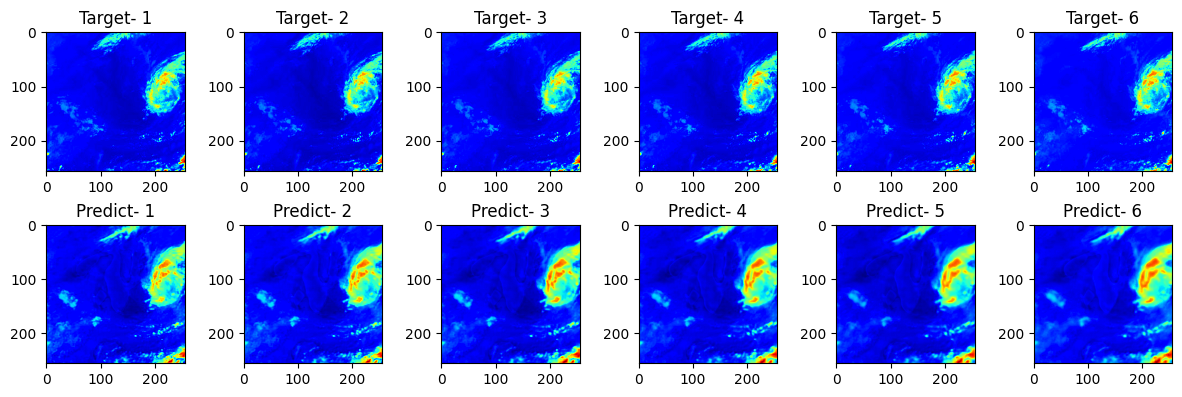

In [92]:
# Create a figure and an array of subplots
fig, axes = plt.subplots(2, 6, figsize=(12,4))

for j in range(6):
    axes[0,j].imshow(t_ds[0,j,:,:],cmap='jet')
    axes[0,j].set_title(f'Target- {j+1}')

for j in range(6):
    axes[1,j].imshow(p_ds[0,j,:,:],cmap='jet')
    axes[1,j].set_title(f'Predict- {j+1}')
# Adjust spacing between subplots
plt.tight_layout()
plt.show()

#### Epoch 100 with dynamic LR on full images
- Epoch 0
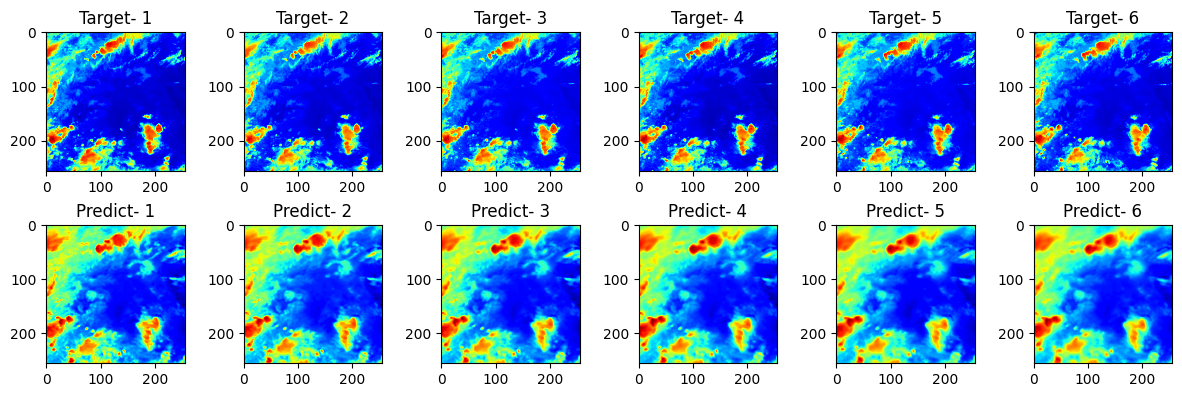

- epoch 20
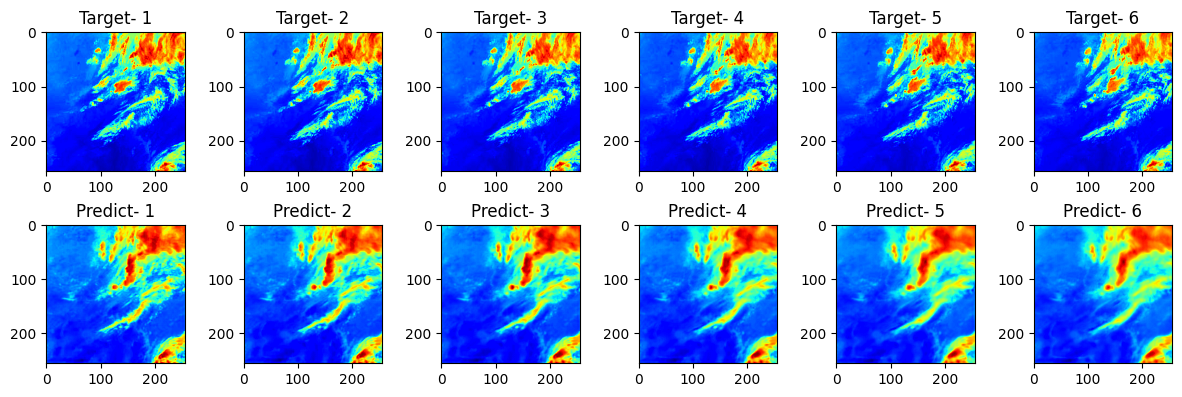

- epoch 40
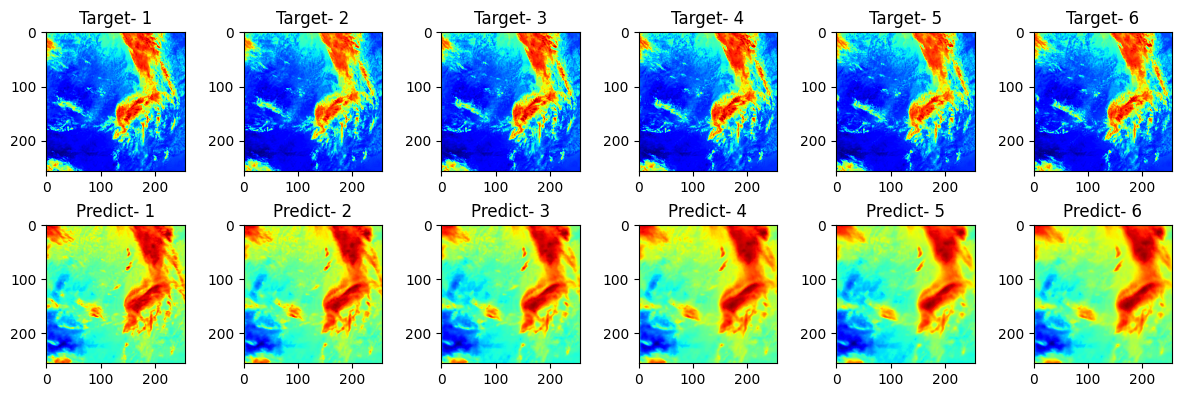

- epoch 60
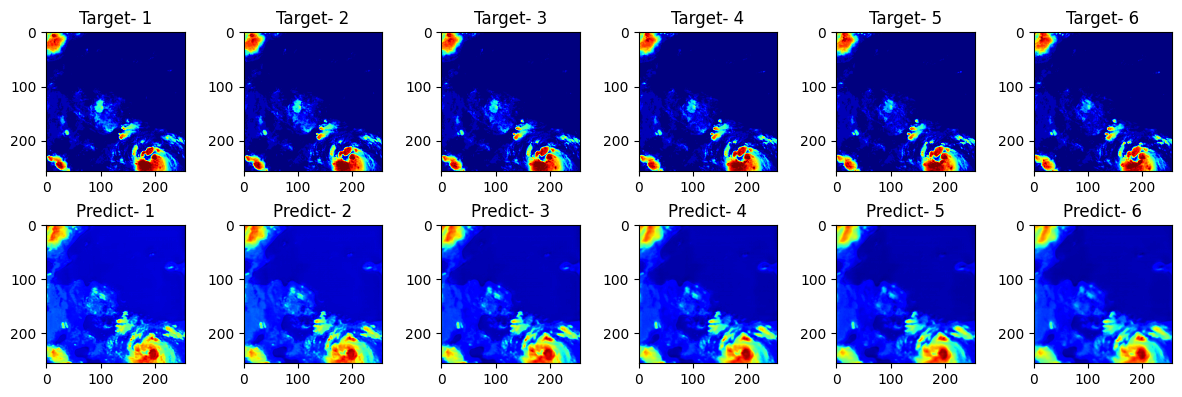

- epoch 80
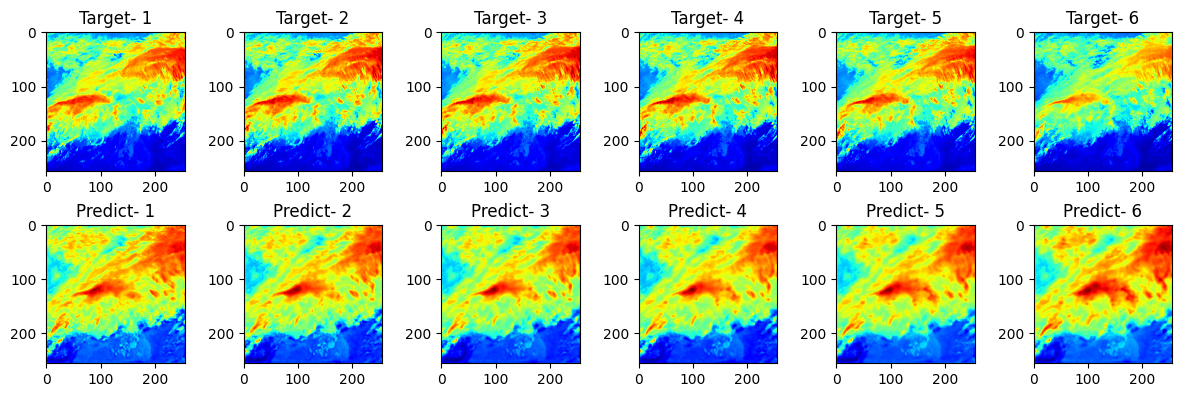

- epoch 95
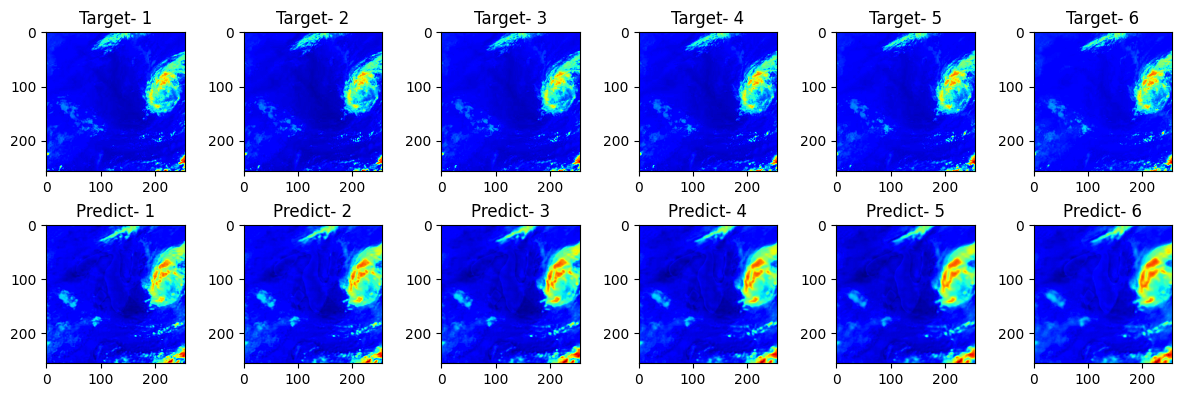

### 6. Test Trained Model

In [93]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model initialization
in_channels = 12  # band08 and band13
out_channels = 6  # Only band13 for output
output_frames = 6

# Initialize the model
model = UNet2D(in_channels=12, out_channels=6,output_frames=6)
model.to(device)

model_save_path =r'D:\Tommy\++AI\himawari9\jvtest\models\unet_2D_AllZones_Dataset_best.pth'
model.load_state_dict(torch.load(model_save_path))

Using device: cuda


<All keys matched successfully>

In [94]:
# Function to load and preprocess the image
def load_image_npy(image_path, pos_start, transform=None):
    ds = np.load(image_path)
    #print(ds.shape)
    imageSet = ds[0,pos_start:pos_start+12,:,:]
    print(imageSet.shape)
    #Normalize current data with range [0,255]
    imageSet = imageSet/255
    print(imageSet.min(), imageSet.max())
    t_images = torch.tensor(imageSet, dtype=torch.float32)
    print(t_images.shape)
    return t_images

In [95]:
# Load and preprocess the input image
image_path = r"D:\Tommy\++AI\++datasets\jv_h9_Data\B13\Groups\np_all_zones_b13_gp1.npy"  
input_image = load_image_npy(image_path,5,transform=transform).to(device)

(12, 256, 256)
0.03529411764705882 0.9137254901960784
torch.Size([12, 256, 256])


In [96]:
test_image = input_image[np.newaxis,:,:,:]
test_image.shape

torch.Size([1, 12, 256, 256])

In [97]:
model.eval()
# Predict
with torch.no_grad():
    output = model(test_image)
    # Apply sigmoid to ensure output is in the [0, 1] range
    output = torch.sigmoid(output)

In [98]:
output.shape

torch.Size([1, 6, 256, 256])

#### Data on Cuda Device needs to be detached to CPU value
`.cpu().numpy()`

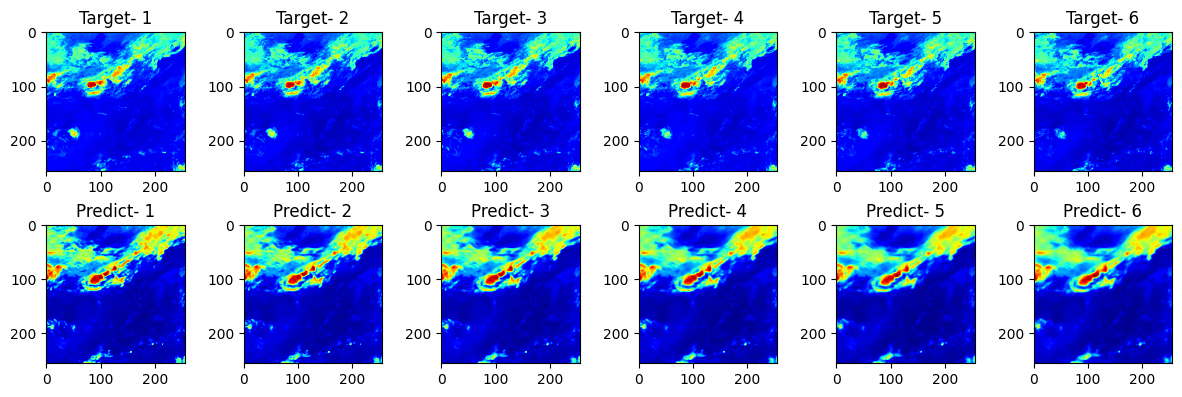

In [99]:
# Create a figure and an array of subplots
fig, axes = plt.subplots(2, 6, figsize=(12,4))

for j in range(6):
    axes[0,j].imshow(test_image[0,j,:,:].cpu().numpy(),cmap='jet')
    axes[0,j].set_title(f'Target- {j+1}')

for j in range(6):
    axes[1,j].imshow(output[0,j,:,:].cpu().numpy(),cmap='jet')
    axes[1,j].set_title(f'Predict- {j+1}')
# Adjust spacing between subplots
plt.tight_layout()
plt.show()